Uses an autoencoder to approximate the habituation/dishabituation process
An autoencoder is afixed ontop of the pre-trained model 
LiMA stim are run through it

Author: VAYZENB

In [1]:
import sys
import os, argparse
from collections import OrderedDict
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import cornet
from torchvision import datasets
import torchvision.models as models
import numpy as np
from LoadFrames import LoadFrames
from statistics import mean
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
exp = ['Exp1', 'Exp2']

skel = [['23','31', '26'],['31_0', '31_50']]
SF = ['Skel', 'Bulge']
#modelType = ['AlexNet_SN', 'ResNet_SN', 'AlexNet_IN', 'ResNet_IN', 'CorNet_Z', 'CorNet_S','SayCam']

batch_num = 10
#hab_min = 4 #minimum number of habituation trials to 
#batch_num = 10 #how many frames to use at a time
#exp = ['Exp1']
#skel=[['23']]
#SF = ['Skel']
#modelType = ['ResNet_SN',  'ResNet_IN', 'CorNet_Z', 'CorNet_S','SayCam']

#Transformations for ImageNet
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])
# specify loss function
criterion = nn.MSELoss()


epochs = 1

#Gets feats for CorNet models
def _store_feats(layer, inp, output):
    """An ugly but effective way of accessing intermediate model features
    """   
    output = output
    _model_feats.append(output)


In [3]:
def save_recon(out_,sk_,sf_, model, stim):
    
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')

    # Show the image
    #ax.imshow(im)

    out_ = out_.squeeze(0)
    out_ = inv_normalize(out_)
    out_ = out_.cpu().detach()
    ax.imshow(out_.permute(1, 2, 0))
    plt.axis('off')
    #print(f'Results/AE/recon/{model}_{fig_fig_}.png')
    plt.savefig(f'Results/AE/recon/{model}_{stim}.png', bbox_inches='tight', pad_inches = 0, dpi=150)
    
    

In [4]:
def load_model(modelType_):
    #select model to run
    if modelType_ == 'AlexNet_IN':
        model = torchvision.models.alexnet(pretrained=True)
        new_classifier = nn.Sequential(*list(model.classifier.children())[:-2])
        model.classifier = new_classifier #replace model classifier with stripped version
        layer = "fc7"
        actNum = 4096
        
    elif modelType_ == 'ResNet_IN':
        model = torchvision.models.resnet50(pretrained=True)
        model = nn.Sequential(*list(model.children())[:-1])
        layer = "avgpool"
        actNum = 2048
                
    elif modelType_ == 'AlexNet_SN':
        model = torchvision.models.alexnet(pretrained=False)
        checkpoint = torch.load('Weights/ShapeNet_AlexNet_Weights.pth.tar')
        model.load_state_dict(checkpoint)
        new_classifier = nn.Sequential(*list(model.classifier.children())[:-2])
        model.classifier = new_classifier #replace model classifier with stripped version
        layer = "fc7"
        actNum = 4096
        
    elif modelType_ == 'ResNet_SN':
        model = torchvision.models.resnet50(pretrained=False)
        checkpoint = torch.load('Weights/ShapeNet_ResNet50_Weights.pth.tar')
        model.load_state_dict(checkpoint)
        model = nn.Sequential(*list(model.children())[:-1])
        
        layer = "avgpool"
        actNum = 2048
    
    elif modelType_ == 'CorNet_Z':
        model = getattr(cornet, 'cornet_z')
        model = model(pretrained=False, map_location='gpu')
        checkpoint = torch.load('Weights/cornet_z.pth')
        model.load_state_dict(checkpoint['state_dict'])
        layer = "avgpool"
        actNum = 512
            
        decode_layer = nn.Sequential(*list(model.children())[0][4][:-3])
        model = nn.Sequential(*list(model.children())[0][:-1])
        model.add_module('4', decode_layer)
        
        
        #try:
        #    m = model.module
        #except:
        #    m = model
        #model_layer = getattr(getattr(m, 'decoder'), layer)
        #model_layer.register_forward_hook(_store_feats)

    elif modelType_ == 'CorNet_S':
        model = getattr(cornet, 'cornet_s')
        model = model(pretrained=False, map_location='gpu')
        checkpoint = torch.load('Weights/cornet_s.pth')
        model.load_state_dict(checkpoint['state_dict'])
        layer = "avgpool"
        actNum = 512        

        decode_layer = nn.Sequential(*list(model.children())[0][4][:-3])
        model = nn.Sequential(*list(model.children())[0][:-1])
        model.add_module('4', decode_layer)
        #try:
        #    m = model.module
        #except:
        #    m = model
        
        #model_layer = getattr(getattr(m, 'decoder'), layer)
        #model_layer.register_forward_hook(_store_feats)

    elif modelType_ == 'SayCam':
        model = torchvision.models.resnext50_32x4d(pretrained=False)
        #model = torch.nn.DataParallel(model)
        #model.fc = torch.nn.Linear(in_features=2048, out_features=n_out, bias=True)
        checkpoint = torch.load('Weights/SayCam_ResNext_Weights.pth.tar')
        model.load_state_dict(checkpoint)
        
        actNum = 2048

        model = nn.Sequential(*list(model.children())[:-1])
        
    return model, actNum

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['CorNet_Z' '23' 'Skel' 35 0.4043169132764301 0.19876533683629766 '23'
 'Skel' 'same' 'same' 6.5771445064775405 None]
['CorNet_Z' '23' 'Skel' 35 0.4043169132764301 0.19876533683629766 '23'
 'Bulge' 'same' 'diff' 11.428362973274723 None]
['CorNet_Z' '23' 'Skel' 35 0.4043169132764301 0.19876533683629766 '31'
 'Skel' 'diff' 'same' 9.18124363114757 None]


KeyboardInterrupt: 

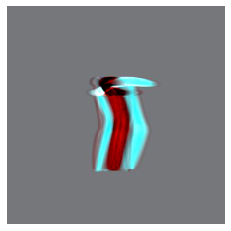

In [12]:

for ee in range(0,len(exp)):
    hab_data = np.load(f'Weights/decoder/{exp[ee]}_Summary.npy',allow_pickle=True)
    
    for mm in range(0, len(hab_data)):
    #for mm in range(0,1):
        
        encoder, in_feat = load_model(hab_data[mm,0]) #load encoder
        #print(hab_data[mm,0])

        encoder = encoder.cuda()
        encoder.eval()
        
        test_data = np.empty(((len(skel[ee]) * len(SF)),hab_data.shape[1]), dtype = object)
        
        hn = 0
        for sk in range(0,len(skel[ee])):
            for sf in SF:
                torch.cuda.empty_cache() #clear GPU memory
                #load stim for dishab object
                hab_dataset = LoadFrames(f'Frames/Figure_{skel[ee][sk]}_{sf}', transform=transform)
                trainloader = torch.utils.data.DataLoader(hab_dataset, batch_size=batch_num, shuffle=True, num_workers = 2, pin_memory=True)
                #print(f'Figure_{skel[ee][sk]}_{sf}')
                
                if skel[ee][sk] == hab_data[mm,1]:
                    skel_cat = "same"
                else:
                    skel_cat = "diff"
                
                if sf == hab_data[mm,2]:
                    sf_cat = "same"
                else:
                    sf_cat = "diff"
                
                #Create decoder
                #it gets reset for every object
                decoder = nn.Sequential(nn.ReLU())
                convT2d = nn.ConvTranspose2d(in_feat, 3, 224)
                #this is  a better initialization ReLu/MSE Loss
                torch.nn.init.kaiming_uniform_(convT2d.weight, a=0, mode='fan_in', nonlinearity='relu') 
                decoder.add_module('1', convT2d)
                decoder = decoder.cuda()

                #Load checkpoint from fully trained decoder
                checkpoint = torch.load(f'Weights/decoder/{exp[ee]}_{hab_data[mm,0]}_Figure_{hab_data[mm,1]}_{hab_data[mm,2]}.pt')
                #print(f'Weights/decoder/{exp[ee]}_{hab_data[mm,0]}_Figure_{hab_data[mm,1]}_{hab_data[mm,2]}.pt')
                decoder.load_state_dict(checkpoint)
                decoder.eval()
                decoder.train() #put in "train mode' because the baby "kinda learns over dishab"
 
                #set up optimzer
                #optimizer = torch.optim.SGD(decoder.parameters(), lr=0.01, momentum=0.9)
                #optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01)
                total_loss = []
                for ep in range(0,epochs):
                    train_loss = 0.0 
                    n = 0
                    for frames in trainloader:
                        frames = frames.cuda()
                        
                        encode_out = encoder(frames) #Get encoder features
                        
                        #optimizer.zero_grad() #zero out gradients from previous epoch
                        
                        decode_out = decoder(encode_out) #Run features through decoder
                                                
                        loss = criterion(decode_out, frames) #Calculate loss
                        train_loss += (loss.item()*frames.size(0))
                        n = n +1

                        # backward pass: compute gradient of the loss with respect to model parameters
                        #loss.backward()
                        # perform a single optimization step (parameter update)
                        #optimizer.step()                        

                        #print(train_loss, loss.item()*frames.size(0), n)
                    total_loss = train_loss/n

                    #print(ep, total_loss)
                    
                               
                if skel_cat == 'same' and sf_cat == 'same':
                    save_recon(decode_out, skel_cat, sf_cat, hab_data[mm,0],f'Figure_{hab_data[mm,1]}_{hab_data[mm,2]}')
                    
                test_data[hn,0:hab_data.shape[1]] =  hab_data[mm]
                test_data[hn,6] =  skel[ee][sk]
                test_data[hn,7] =  sf
                test_data[hn,8] =  skel_cat
                test_data[hn,9] =  sf_cat
                test_data[hn,10] = total_loss
                
                
                #test_data[hn,11] =  []
                #test_data[hn,11:test_data.shape[1]] =  total_loss
                #hab_data[hn,9] =  hab_end
                
                print(test_data[hn])
                hn = hn +1
        #print('Saving model', modelType[mm], f'Figure_{skel[ee][sk]}_{sf}', ep, hab_start, hab_end)                
        #torch.save(decoder.state_dict(), f'Weights/decoder/{exp[ee]}_{modelType[mm]}_Figure_{skel[ee][sk]}_{sf}.pt')
        #np.savetxt(f'Results/AE/{exp[ee]}_{hab_data[mm,0]}_Figure_{hab_data[mm,1]}_{hab_data[mm,2]}_Result.csv', test_data, delimiter=',', fmt= '%s')
        #hn = hn + 1
        
        #del decoder
        #del encoder
    

In [ ]:
print(hab_data[mm])

In [ ]:
sk = '23'
sf = 'Skel'
model = 'ResNet_SN'
ee = 0

In [ ]:
sk = hab_data[mm,1]
sf = hab_data[mm,2]
model = hab_data[mm,0]
ee = 0

In [ ]:
encoder, in_feat = load_model(model) #load encoder
encoder.cuda()
encoder.eval()
#Create decoder
#it gets reset for every object
decoder = nn.Sequential(nn.ReLU(), nn.ConvTranspose2d(in_feat, 3, 224))
decoder = decoder.cuda()

#Load checkpoint from fully trained decoder
checkpoint = torch.load(f'Weights/decoder/{exp[ee]}_{model}_Figure_{sk}_{sf}.pt')
decoder.load_state_dict(checkpoint)
decoder.eval()
decoder.train()
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01)

In [ ]:
hab_dataset = LoadFrames(f'Frames/Figure_{sk}_{sf}', transform=transform)
trainloader = torch.utils.data.DataLoader(hab_dataset, batch_size=batch_num, shuffle=True, num_workers = 0, pin_memory=False)

In [ ]:
train_loss = 0.0 
n = 0
for frames in trainloader:
    frames = frames.cuda()


    encode_out = encoder(frames) #Get encoder features

    optimizer.zero_grad() #zero out gradients from previous epoch

    decode_out = decoder(encode_out) #Run features through decoder

    loss = criterion(decode_out, frames) #Calculate loss
    print((loss.item()*frames.size(0)))
    train_loss += (loss.item()*frames.size(0))
    n = n +1


    # backward pass: compute gradient of the loss with respect to model parameters
    #loss.backward()
    # perform a single optimization step (parameter update)
    #optimizer.step()
    optimizer.zero_grad() #zero out gradients from previous epoch



    #print(train_loss, loss.item()*frames.size(0), n)
print(train_loss/n)

#print(ep, total_loss)

In [ ]:
#scaler = transforms.Resize((224, 224))
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])
#to_tensor = transforms.ToTensor()
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    #image = Variable(normalize(to_tensor(scaler(image))).unsqueeze(0))
    image = transform(image).unsqueeze(0)
    
    return image     

In [ ]:
#load sample image
IM = image_loader(f'Frames/Figure_{sk}_{sf}/Figure_{sk}_{sf}_150.jpg')
IM = IM.cuda()
print(IM.shape)

In [ ]:
print(f'Weights/decoder/{exp[ee]}_{model}_Figure_{sk}_{sf}.pt')
print(IM.shape)


In [ ]:

out = encoder(IM)
out = decoder(out)
loss = criterion(out, IM)
print(loss.item()*IM.size(0))
#out = out.squeeze(0)
#print(out.shape)

From here on is image preview

In [ ]:
out = out.squeeze(0)
print(out.shape)
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

output = inv_normalize(out)
output = output.cpu().detach()
plt.imshow(output.permute(1, 2, 0))

In [ ]:
IM = IM.squeeze(0)
IM = inv_normalize(IM)
IM = IM.cpu().detach()
plt.imshow(IM.permute(1, 2, 0))

From here on is image preview